In [6]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env
import numpy as np
from typing import Optional, Union
import math

from gym import spaces
from gym.utils import seeding
import matplotlib as plt
import random
import os

from matplotlib import patches, animation
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.lines import Line2D

# To register this module as a gym envir
register(
    id='acasxu-v0',
    entry_point='acas_xu_env:AcasEnv'
)


def rad_mod(angle):
    """return angle between -pi and +pi"""
    return ( (angle + np.pi) % (np.pi*2) ) - np.pi

###############################################################################


def plot_state(encounter, fig=None, animate=False, frames=12, show=True):

    """own displacement in m in 10 seconds"""
    d_own = encounter.v_own/0.3281
    
    """int displacement in m in 10 seconds"""
    d_int = encounter.v_int/0.3281
    
    """intruder position"""
    x = encounter.rho * math.cos(encounter.theta)
    y = encounter.rho * math.sin(encounter.theta)
    
    """intruder displacement"""
    """psi = 0 means intruder flying in the same sense than own"""
    dx = d_int * np.cos(encounter.psi)
    dy = d_int * np.sin(encounter.psi)

    #lim = 2.3 * max(x, y)

    if fig is None:    
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    #ax.set_xlim(-lim, lim)
    #ax.set_ylim(-lim, lim)

    """draw distance"""
    ax.annotate('', xytext=(x,y), xy=(0,0), arrowprops=dict(arrowstyle="-", linestyle="--", shrinkA=0, shrinkB=0, alpha=0.5))
    ax.annotate(f'$\\rho = {round(encounter.rho/1000,1)}$ Km', xy=(x//2 + encounter.v_own, y//2), xycoords='data')
    
    """ draw own speed"""
    ax.annotate('', xytext=(0,0), xy=(d_own,0), arrowprops=dict(arrowstyle='->'))
    ax.text(encounter.v_own, -2*encounter.v_own, str(round(d_own/1000,1)) + "Km in 10s")
    """draw own linear trajectory"""
    ax.annotate('', xy=(12*encounter.v_own,0), xytext=(0,0), arrowprops=dict(arrowstyle="-", linestyle=":", color='b', shrinkA=0, shrinkB=0, alpha=0.5))
    """draw intruder speed"""
    ax.annotate('', xytext=(x,y), xy=(x+dx,y+dy), arrowprops=dict(arrowstyle='->'))
    """draw own position"""
    ax.scatter(0, 0)
    ax.scatter(d_own, 0, alpha=0)
    """ draw intruder position"""
    ax.scatter(x, y)
    ax.scatter(x+dx, y+dy, alpha=0)
    
    """ draw intruder angle"""
    r = encounter.v_int
    arc_angles = np.linspace(0, encounter.psi, 20)
    arc_xs = r * np.cos(arc_angles)
    arc_ys = r * np.sin(arc_angles)
    ax.plot(arc_xs+x, arc_ys+y, lw = 1, color='k', alpha=0.5)
    ax.annotate(f'$\\psi = {round(np.degrees(encounter.psi),1)}\\degree$', xy=(x+encounter.v_int, y+encounter.v_int//2), xycoords='data')
    
    """draw intruder reference own heading"""
    ax.annotate('', xy=(x+2*encounter.v_int,y), xytext=(x,y), arrowprops=dict(arrowstyle="-", linestyle=":", color='g', shrinkA=0, shrinkB=0, alpha=0.5))

    """draw theta angle and annotation"""
    r = encounter.v_own
    arc_angles = np.linspace(0, encounter.theta, 20)
    arc_xs = r * np.cos(arc_angles)
    arc_ys = r * np.sin(arc_angles)
    ax.plot(arc_xs, arc_ys, lw = 1, color='k', alpha=0.5)
    ax.annotate(f'$\\theta = {round(np.degrees(encounter.theta),1)}\\degree$', xy=(encounter.v_own, encounter.v_own//2), xycoords='data')
    #plt.gca().annotate('<----- r = 1.5 ---->', xy=(0 - 0.2, 0 + 0.2), xycoords='data', fontsize=15, rotation = 45)
    
    ax.set_aspect('equal')
    
    ax.set_title("displacement (interval = $10s$)")
    
    if animate:
       """ draw own final position"""
       ax.scatter(frames*d_own, 0)
       """draw intruder final position"""
       ax.scatter(x+frames*dx, y+frames*dy)
    
       def animate(n):
          own_traj_coordinates = np.array([(0,0), ((n+1)*d_own, 0)])
          own_lines, = ax.plot(own_traj_coordinates[:,0], own_traj_coordinates[:,1], alpha=0.4, color='b')
          intruder_traj_coordinates = np.array([(x,y), (x+(n+1)*dx, y+(n+1)*dy)])
          intruder_lines, = ax.plot(intruder_traj_coordinates[:,0], intruder_traj_coordinates[:,1], alpha=0.4, color='g')
          return own_lines, intruder_lines
       
       anim = FuncAnimation(fig, animate, frames=frames, interval=500, repeat=False, blit=True)
    
    if show:
        plt.show()
    
    if animate:
        return anim
    else:
        return None
 

class Airplane():

    def __init__(self, x=0.0, y=0.0, head=0.0, speed=100.0, name='airplane'):
        self.x = x   
        self.y = y   
        self.head = head  # in rad
        self.speed = speed  # distance per unit of time (on heading direction)
        self.name=name
        self.last_a=0

    def __str__(self):
        return f"x: {self.x}, y: {self.y}, head: {self.head}, speed: {self.speed}"

# TODO supprimer ou modifier ? 
class Encounter:

    def __init__(self, *, last_a=0, v_own=50.0, v_int=0.0, theta=0.0, psi=0.0, rho=499., tau=0.0):
        #input values
        self.last_a = last_a #ça fait quoi ça ?  
        self.v_own = v_own   
        self.v_int = v_int
        self.theta = theta
        self.psi = psi
        self.rho = rho
        self.tau = tau

    def __getitem__(self, arg:str):
        return getattr(self, arg, None)

    def __str__(self):
        return  f"last_a={self.last_a}, v_own={self.v_own}, v_int={self.v_int}, theta={self.theta}, psi={self.psi}, rho={self.rho}, tau={self.tau}"


class AcasEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    act_to_angle = [0, np.radians(-1.5), np.radians(+1.5), np.radians(-3.), np.radians(+3.)]

    def __init__(self, 
                 save_states=False,
                 render_mode=None,
                 airplanes = [Airplane(name='own'), Airplane(x=5000.0, y=1000.0, head=-3.0, name='intruder')],
                 epsilon = 0.01,
                 max_time_steps=500, step=0):
        self.last_a=0
        self.epsilon = epsilon
        self.airplanes = airplanes
        self.save_states=save_states # state save 
        self.states_history = [] # state history
        self.commands_history = [] # commands history
        self.own=airplanes[0]
        self.int = airplanes[1]
        self.rho = np.sqrt((self.own.x-self.int.x)**2 +(self.own.y-self.int.y)**2)
        self.min_dist = 0
        self.max_time_steps = max_time_steps
        

        #Initial values
        self.first_step = True
        self.done = False
        self.info = {}
        self.current_time_step = 0

        #ACTION DISCRETIZATION : 0,1,2,3,4 (COC, WR, WL, R, L) => we have 5 possible actions
        self.action_space = spaces.Discrete(5) 

        self.observation_space = spaces.Box(
            low = -np.inf,
            high = np.inf,
            shape=(6,), # la taille du vecteur qu'on observe, own_x, own_y, head_own, int_x,int_y, head_int
            dtype=np.float32
        )
        

    def __str__(self):
        return "\n".join([f"x: {airplane.x}, y: {airplane.y}, head: {airplane.head_rad}" for airplane in self.airplanes])

    
    def update_relations(self):

        # Could be a triangular matrix representation
        self.relative_distances = np.array([[np.hypot(own.x-intruder.x, own.y-intruder.y) for intruder in self.airplanes] for own in self.airplanes])
        for i in range(len(self.airplanes)):
            self.relative_distances[i,i] = np.inf
        self.nearest_intruder_index = self.relative_distances.argmin(axis=-1)
        self.relative_angles = np.array([[rad_mod(np.arctan2(intruder.y-own.y, intruder.x-own.x)) for intruder in self.airplanes] for own in self.airplanes])
        self.relative_heads = np.array([[rad_mod(intruder.head-own.head) for intruder in self.airplanes] for own in self.airplanes])
        #self.rho = np.array([np.sqrt((own.x-intruder.x)**2 +(own.y-intruder.y)**2) for intruder, own in self.airplanes])
        self.rho = np.array([self.relative_distances[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.theta = np.array([self.relative_angles[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.psi = np.array([self.relative_heads[i, self.nearest_intruder_index[i]] for i in range(len(self.airplanes))])
        self.v_int = np.array([self.airplanes[self.nearest_intruder_index[i]].speed for i in range(len(self.airplanes))])
        self.min_dist = self.rho.min()



    """
    Function to get the  observation of the state:
    rho :minimal distance between the planes,
    theta: angle of the ownship,
    psi: angle of the intruder,
    v_own: velocity of ownship, 
    v_int: velocity of intruder """

    def _get_obs(self):
        #return [[self.rho[i], self.theta[i], self.psi[i], own.speed, self.v_int[i]] for i, own in enumerate(self.airplanes)]
        #return [Encounter(rho=self.rho[i], theta=self.theta[i], psi=self.psi[i], v_own=own.speed, v_int=self.v_int[i]) for i, own in enumerate(self.airplanes)]

        own = self.airplanes[0]
        intruder = self.airplanes[1]
        return [self.rho, own.speed, intruder.speed, self.theta, self.psi, self.last_a]
   
    "Petite fonction get_info pour avoir la distance entre l'ownship et la destination finale A REFAIREE" #TODO
    def _get_info(self):
        own = self.airplanes[0]
        intruder = self.airplanes[1]
        return {own.head, own.x, own.y, intruder.head, intruder.x, intruder.y }


    def reset(self,*, seed: Optional[int]=None, options: Optional[dict] =None):

        # we need this line to seed self.np_random
        super().reset(seed=seed)

        self.update_relations()
        
        observation = self._get_obs()
        info = {}
        #info = self._get_info()
        

        self.current_time_step=0
        if self.render_mode == "human":
            self.render()

        return observation, info

    def step(self, action):
        """
        Make an action in the environnement. The action is chosen by the policy. 
        @type action : 
        @return : observation, truncated, terminated, info
        @rtype : obsType, Float, bool, bool, dict[str, Any]
        The observation space is a list of : rho, ownship's speed, intruder's speed, ownship's angle, Intruder's angle, minimum distance 
        between the two airplanes. 
        """
      
        own = self.airplanes[0]
        int=self.airplanes[1]


        own.head = rad_mod(own.head + self.act_to_angle[action])
        own.x += np.cos(own.head) * own.speed
        own.y += np.sin(own.head) * own.speed

        int.x+=np.cos(int.head) * int.speed
        int.y+=np.sin(int.head) * int.speed


        self.update_relations()

        self.current_time_step += 1
        #condition_reversal = (self.commands_history[-2]==1 and self.commands_history[-1]==2) or (self.commands_history[-2]==1 and self.commands_history[-1]==4) or (self.commands_history[-2]==1 and self.commands_history[-1]==2)
        
        reward=0

        if (action==0):
            reward +=0.0001
        elif ((self.last_a==1 and action==3)or (self.last_a==2 and action==4)):
            reward -= 0.009
        # Reversal
        # Right to left
        elif ((self.last_a==1 or self.last_a==3) and (action==2 or action==4)):
            reward -= 0.01
        # Left to right
        elif ((self.last_a==2 or self.last_a==4) and (action==3 or action==1)):
            reward -= 0.01
        elif self.rho[-1] < self.epsilon :
            reward = -1
        terminated = (self.rho[-1] < self.epsilon)
        truncated =  (self.current_time_step == self.max_time_steps) #TODO time_steps == max  

        
        self.last_a=action
        obs = self._get_obs()
        info = self._get_info()
 
        return obs, reward, terminated, truncated, info

    def render(self):
        #TODO visualisation : voir le code originel (animation)
        pass
    


/tmp/ipykernel_28464/3813243591.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


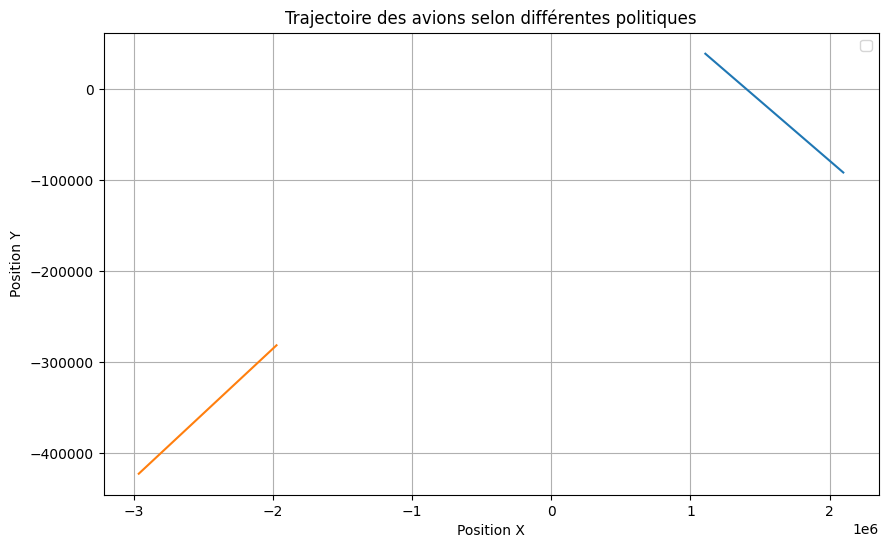

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Supposons que AcasEnv est l'environnement que nous avons déjà implémenté
env = AcasEnv(render_mode=None)  # Pas besoin de "render_mode" pour le test

def simulate_policy(env, policy, num_steps=100):
    # Reset environment
    obs, _ = env.reset()
    
    positionsxown = []
    positionsyown = []
    positionsxint = []
    positionsyint = []
    for step in range(num_steps):
        action = policy(obs)  # Applique la politique pour obtenir l'action
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Sauvegarder la position de l'avion (ou des avions)
        own_x, own_y = env.airplanes[0].x, env.airplanes[0].y
        int_x, int_y = env.airplanes[1].x, env.airplanes[1].y
        positionsxown.append(own_x)
        positionsyown.append(own_y)
        positionsxint.append(int_x)
        positionsyint.append(int_y)

        

    return positionsxown,positionsyown,positionsxint,positionsyint

# Politique de vol en ligne droite (action 0 -> pas de changement de direction)
def straight_policy(obs):
    return 0  # Action "0" signifie aucun changement d'angle

# Politique aléatoire
def random_policy(obs):
    return env.action_space.sample()  # Choisir une action aléatoire

# Simuler les deux politiques
num_steps = 10000  # Nombre d'étapes à simuler

# Simulation de la politique de vol en ligne droite
straight_positions = simulate_policy(env, straight_policy, num_steps)

# Simulation de la politique aléatoire
random_positions = simulate_policy(env, random_policy, num_steps)

# Fermer l'environnement
env.close()


positionsxown=straight_positions[0]
positionsyown=straight_positions[1]
positionsxint=straight_positions[2]
positionsyint=straight_positions[3]

# Afficher les résultats des trajectoires
plt.figure(figsize=(10, 6))

# Trajectoire en ligne droite




plt.plot(np.array(positionsxown),np.array(positionsyown))
plt.plot(np.array(positionsxint),np.array(positionsyint))

# Trajectoire aléatoire
#plt.plot(random_positions[:, 0], random_positions[:, 1], label="Vol avec politique aléatoire", marker='x')

plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()
plt.title("Trajectoire des avions selon différentes politiques")
plt.grid(True)
plt.show()
